# <center> Тема 6. Побудова й відбір ознак</center>

<a class="anchor" id="6"></a>

## Зміст

- [6.1. Извлечение признаков (Feature Extraction)](#6.1)
    + [6.1.1. Тексты](#6.1.1)
    + [6.1.2. Изображения](#6.1.2)
    + [6.1.3. Геоданные](#6.1.3)
    + [6.1.4. Дата и время](#6.1.4)
    + [6.1.5. Временные ряды, веб и прочее](#6.1.5)   
- [6.2. Преобразования признаков (Feature transformations)](#6.2)
    + [6.2.1. Нормализация и изменение распределения](#6.2.1)
    + [6.2.2. Взаимодействия (Interactions)](#6.2.2)
    + [6.2.3. Заполнение пропусков](#6.2.3) 
- [6.3. Выбор признаков (Feature selection)](#6.3)
    + [6.3.1. Статистические подходы](#6.3.1)
    + [6.3.2. Отбор с использованием моделей](#6.3.2)
    + [6.3.3. Перебор](#6.3.2)

В рамках курсу ми вже познайомилися з кількома ключовими алгоритмами машинного навчання (МН). Однак перед тим як переходити до більш складних алгоритмів і підходів, зробимо крок в сторону і поговоримо про підготовку даних для навчання моделі. Відомий принцип garbage in - garbage out на 100% застосовуваний щодо будь-якого завдання МН; будь-який досвідчений інженер може згадати приклади з практики, коли проста модель, навчена на якісно підготовлених даних, показала себе краще хитромудрого ансамблю, побудованого на недостатньо чистих даних.

В поточній лекції розглянемо три схожих завдання в задачі підготовки та оброблення ознак:
* **feature extraction** і **feature engineering** – перетворення даних, специфічних для предметної області, у вектори, що є зрозумілими для моделі;
* **feature transformation** – трансформація даних для підвищення точності алгоритму;
* **feature selection** – відсікання непотрібних ознак.

У прикладах до лекції будемо використовувати набір даних компанії Renthop із змагання [Two Sigma Connect: Rental Listing Inquiries Kaggle competition](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries).

У цьому завданні потрібно передбачити популярність оголошення щодо оренди нерухомості, тобто розв'язати задачу класифікації з трьома класами `['low', 'medium', 'high']`. Для оцінки розв'язку використовується метрика log loss (чим менше - тим краще). 

In [3]:
import json
import pandas as pd

# Відразу завантажимо набір даних з Renthop
with open('train.json', 'r') as raw_data:
    data = json.load(raw_data)
    df = pd.DataFrame(data)

<a class="anchor" id="6.1"></a>

## <span style="color:blue; font-size:1.2em;">6.1. Извлечение признаков (Feature Extraction)</span>

[Повернутися до змісту](#6)

В жизни редко данные приходят в виде готовых матриц, потому любая задача начинается с извлечения признаков. Иногда, конечно, достаточно прочитать csv файл и сконвертировать его в `numpy.array`, но это счастливые исключения. Давайте посмотрим на некоторые популярные типы данных, из которых нужно извлекать признаки.

<a class="anchor" id="6.1.1"></a>

### <span style="color:blue; font-size:1.2em;"> 6.1.1. Тексты</span>

[Повернутися до змісту](#6)

Текст – самый очевидный пример данных в свободном формате; методов работы с текстом достаточно, чтобы они не уместились в одну статью. Тем не менее, обзорно пройдем по самым популярным.


Перед тем как работать с текстом, его необходимо токенизировать. Токенизация предполагает разбиение текста на токены – в самом простом случае это просто слова. Но, делая это слишком простой регуляркой ("в лоб"), мы можем потерять часть смысла: "Нижний Новгород" это не два токена, а один. Зато призыв "воруй-убивай!" можно напрасно разделить на два токена. Существуют готовые токенайзеры, которые учитывают особенности языка, но и они могут ошибаться, особенно если вы работаете со специфическими текстами (профессиональная лексика, жаргонизмы, опечатки).


После токенизации в большинстве случаев нужно задуматься о приведении к нормальной форме. Речь идет о стемминге и/или лемматизации – это схожие процессы, используемые для обработки словоформ. О разнице между ними можно прочитать [здесь](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html).


Итак, мы превратили документ в последовательность слов, можно начинать превращать их в вектора. Самый простой подход называется Bag of Words: создаем вектор длиной в словарь, для каждого слова считаем количество вхождений в текст и подставляем это число на соответствующую позицию в векторе. В коде это выглядит даже проще, чем на словах:

In [4]:
from functools import reduce 
import numpy as np

texts = [['i', 'have', 'a', 'cat'], 
        ['he', 'have', 'a', 'dog'], 
        ['he', 'and', 'i', 'have', 'a', 'cat', 'and', 'a', 'dog']]

dictionary = list(enumerate(set(list(reduce(lambda x, y: x + y, texts)))))

def vectorize(text): 
    vector = np.zeros(len(dictionary)) 
    for i, word in dictionary: 
        num = 0 
        for w in text: 
            if w == word: 
                num += 1 
        if num: 
            vector[i] = num 
    return vector

for t in texts: 
    print(vectorize(t))

[1. 1. 1. 1. 0. 0. 0.]
[1. 0. 0. 1. 1. 0. 1.]
[2. 1. 1. 1. 1. 2. 1.]


Также идея хорошо иллюстрируется картинкой:

<img src="https://raw.githubusercontent.com/radiukpavlo/Intelligent-data-analysis/main/03_img/4_2_10_bag_of_words.png" align="center" width=80% height=80%>

Это предельно наивная реализация. В реальной жизни нужно позаботиться о стоп-словах, максимальном размере словаря, эффективной структуре данных (обычно текстовые данные превращают в разреженные вектора)…

Используя алгоритмы вроде Вag of Words, мы теряем порядок слов в тексте, а значит, тексты "i have no cows" и "no, i have cows" будут идентичными после векторизации, хотя и противоположными семантически. Чтобы избежать этой проблемы, можно сделать шаг назад и изменить подход к токенизации: например, использовать N-граммы (*комбинации* из N последовательных терминов).

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(ngram_range=(1,1))
vect.fit_transform(['no i have cows', 'i have no cows']).toarray()

array([[1, 1, 1],
       [1, 1, 1]], dtype=int64)

In [6]:
vect.vocabulary_ 

{'no': 2, 'have': 1, 'cows': 0}

In [7]:
vect = CountVectorizer(ngram_range=(1,2))
vect.fit_transform(['no i have cows', 'i have no cows']).toarray()

array([[1, 1, 1, 0, 1, 0, 1],
       [1, 1, 0, 1, 1, 1, 0]], dtype=int64)

In [8]:
vect.vocabulary_

{'no': 4,
 'have': 1,
 'cows': 0,
 'no have': 6,
 'have cows': 2,
 'have no': 3,
 'no cows': 5}

Также нужно отметить, что необязательно оперировать именно словами: в некоторых случаях можно генерировать N-граммы из букв (например, такой алгоритм учтет сходство родственных слов или опечаток).

In [9]:
from scipy.spatial.distance import euclidean
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(ngram_range=(3,3), analyzer='char_wb')

n1, n2, n3, n4 = vect.fit_transform(['andersen', 'petersen', 'petrov', 'smith']).toarray()

euclidean(n1, n2), euclidean(n2, n3), euclidean(n3, n4)

(2.8284271247461903, 3.1622776601683795, 3.3166247903554)

Развитие идеи Bag of Words: слова, которые редко встречаются в корпусе (во всех рассматриваемых документах этого набора данных), но присутствуют в этом конкретном документе, могут оказаться более важными. Тогда имеет смысл повысить вес более узкотематическим словам, чтобы отделить их от общетематических. Этот подход называется TF-IDF, его уже не напишешь в десять строк, потому желающие могут ознакомиться с деталями во внешних источниках вроде [wiki](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). Вариант по умолчанию выглядит так:


$$ \large idf(t,D) = \log\frac{\mid D\mid}{df(d,t)+1} $$

$$ \large tfidf(t,d,D) = tf(t,d) \times idf(t,D) $$

Аналоги Bag of words могут встречаться и за пределами текстовых задач: например, bag of sites в  [Catch Me If You Can competition](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking), [bag of apps](https://www.kaggle.com/xiaoml/talkingdata-mobile-user-demographics/bag-of-app-id-python-2-27392), [bag of events](http://www.interdigital.com/download/58540a46e3b9659c9f000372), etc.

Используя такие алгоритмы, можно получить вполне рабочее решение несложной проблемы, эдакий baseline. Впрочем, для нелюбителей классики есть и более новые подходы. Самый распиаренный метод новой волны – Word2Vec, но есть и альтернативы (Glove, Fasttext…).

Word2Vec является частным случаем алгоритмов Word Embedding. Используя Word2Vec и подобные модели, мы можем не только векторизовать слова в пространство большой размерности (обычно несколько сотен), но и сравнивать их семантическую близость. Классический пример операций над векторизированными представлениями: king – man + woman = queen.

<img src="https://raw.githubusercontent.com/radiukpavlo/Intelligent-data-analysis/main/03_img/6_1_1_king-man%2Bwoman.gif" align="center" width=50% height=50%>

Стоит понимать, что эта модель, конечно же, не обладает пониманием слов, а просто пытается разместить вектора таким образом, чтобы слова, употребляемые в общем контексте, размещались недалеко друг от друга. Если это не учитывать, то можно придумать много курьезов: например, найти противоположность Гитлеру путем умножения соответствующего вектора на -1.

Такие модели должны обучаться на очень больших наборах данных, чтобы координаты векторов действительно отражали семантику слов. Для решения своих задач можно скачать предобученную модель, например, [здесь](https://github.com/3Top/word2vec-api#where-to-get-a-pretrained-models).

Похожие методы, кстати, применяются и других областях (например, в биоинформатике). Из совсем неожиданных применений – [food2vec](https://jaan.io/food2vec-augmented-cooking-machine-intelligence/). Вы так же можете подумать о нескольких других свежих идеях; концепция достаточно универсальна.

<a class="anchor" id="6.1.2"></a>

### <span style="color:blue; font-size:1.2em;">6.1.2. Изображения</span>

[Повернутися до змісту](#6)

В работе с изображениями все и проще, и сложнее одновременно. Проще, потому что часто можно вообще не думать и пользоваться одной из популярных предобученных сетей; сложнее, потому что если нужно все-таки детально разобраться, то эта кроличья нора окажется чертовски глубокой. Впрочем, обо всем по порядку.


Во времена, когда GPU были слабее, а "ренессанс нейросетей" еще не случился, генерация фичей из картинок была отдельной сложной областью. Для работы с картинками нужно было работать на низком уровне, определяя, например, углы, границы областей и так далее. Опытные специалисты в компьютерном зрении могли бы провести много параллелей между более старыми подходами и нейросетевым хипстерством: в частности, сверточные слои в современных сетях очень похожи на [каскады Хаара](https://en.wikipedia.org/wiki/Haar-like_feature). Оставим пару ссылок на библиотеки [skimage](http://scikit-image.org/docs/stable/api/skimage.feature.html) и [SimpleCV](http://simplecv.readthedocs.io/en/latest/SimpleCV.Features.html) и перейдём сразу к нашим дням.


Часто для задач, связанных с картинками, используется какая-нибудь сверточная сеть. Можно не придумывать архитектуру и не обучать сеть с нуля, а взять предобученную state of the art сеть, веса которой можно скачать из открытых источников. Чтобы адаптировать ее под свою задачу, дата сайнтисты практикуют т.н. fine tuning: последние полносвязные слои сети "отрываются", вместо них добавляются новые, подобранные под конкретную задачу, и сеть дообучается на новых данных. Но если вы хотите просто векторизовать изображение для каких-то своих целей (например, использовать какой-то несетевой классификатор) – просто оторвите последние слои и используйте выход предыдущих слоев:

In [10]:
# Install Keras (https://keras.io/)
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image 
from scipy.misc import face 
import numpy as np

resnet_settings = {'include_top': False, 'weights': 'imagenet'}
resnet = ResNet50(**resnet_settings)

# Какой милый енот!
img = image.array_to_img(face())
img

ModuleNotFoundError: No module named 'keras'

In [11]:
# В реальной жизни может понадобиться внимательнее относиться к ресайзу
img = img.resize((224, 224))

x = image.img_to_array(img) 
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Нужно дополнительное измерение, т.к. модель рассчитана на работу с массивом изображений

features = resnet.predict(x)

NameError: name 'img' is not defined

<img src="https://raw.githubusercontent.com/radiukpavlo/Intelligent-data-analysis/main/03_img/6_1_2_neural-net.png" align="center" width=80% height=80%>

*Классификатор, обученный на одном датасете и адаптированный для другого путем "отрыва" последнего слоя и добавления нового взамен.*

Тем не менее, не стоит зацикливаться на нейросетевых методах. Некоторые признаки, сгенерированные руками, могут оказаться полезными и в наши дни: например, предсказывая популярность объявлений об аренде квартиры, можно предположить, что светлые квартиры больше привлекают внимание, и сделать признак "среднее значение пикселя". Вдохновиться примерами можно в документации соответствующих [библиотек](http://pillow.readthedocs.io/en/3.1.x/reference/ImageStat.html).


Если на картинке ожидается текст, его также можно прочитать и не разворачивая своими руками сложную нейросеть: например, при помощи [pytesseract](https://github.com/madmaze/pytesseract).

In [12]:
import pytesseract
from PIL import Image
import requests
from io import BytesIO

# Просто случайная картинка из поиска 
img = 'http://ohscurrent.org/wp-content/uploads/2015/09/domus-01-google.jpg'

img = requests.get(img)
img = Image.open(BytesIO(img.content))
text = pytesseract.image_to_string(img)

text

ModuleNotFoundError: No module named 'pytesseract'

Надо понимать, что `pytesseract` – далеко не панацея:

In [ ]:
# На этот раз возьмем картинку от Renthop
img = requests.get('https://photos.renthop.com/2/8393298_6acaf11f030217d05f3a5604b9a2f70f.jpg')
img = Image.open(BytesIO(img.content))
pytesseract.image_to_string(img)

Еще один случай, когда нейросети не помогут – извлечение признаков из метаинфорации. А ведь в EXIF может храниться много полезного: производитель и модель камеры, разрешение, использование вспышки, геокоординаты съемки, использованный для обработки софт и многое другое.

<a class="anchor" id="6.1.3"></a>

### <span style="color:blue; font-size:1.2em;"> 6.1.3. Геоданные</span>

[Повернутися до змісту](#6)

Географические данные не так часто попадаются в задачах, но освоить базовые приемы для работы с ними также полезно, тем более, что в этой сфере тоже хватает готовых решений.


Геоданные чаще всего представлены в виде адресов или пар "широта + долгота", т.е. точек. В зависимости от задачи могут понадобиться две обратные друг другу операции: геокодинг (восстановление точки из адреса) и обратный геокодинг (наоборот). И то, и другое осуществимо при помощи внешних API вроде Google Maps или OpenStreetMap. У разных геокодеров есть свои особенности, качество разнится от региона к региону. К счастью, есть универсальные библиотеки вроде [geopy](https://github.com/geopy/geopy), которые выступают в роли оберток над множеством внешних сервисов.


Если данных много, легко упереться в лимиты внешних API. Да и получать информацию по HTTP – далеко не всегда оптимальное по скорости решение. Поэтому стоит иметь в виду возможность использования локальной версии OpenStreetMap.


Если данных немного, времени хватает, а желания извлекать наворченные признаки нет, то можно не заморачиваться с OpenStreetMap и воспользоваться `reverse_geocoder`:

In [14]:
import reverse_geocoder as revgc

revgc.search((df.latitude, df.longitude))
#Loading formatted geocoded file... 

Out: [OrderedDict([('lat', '40.74482'), 
                   ('lon', '-73.94875'), 
                   ('name', 'Long Island City'), 
                   ('admin1', 'New York'), 
                   ('admin2', 'Queens County'), 
                   ('cc', 'US')])]

ModuleNotFoundError: No module named 'reverse_geocoder'

Работая с геокодингом, нельзя забывать о том, что адреса могут содержать опечатки, соответственно, стоит потратить время на очистку. В координатах опечаток обычно меньше, но и с ними не все хорошо: GPS по природе данных может "шуметь", а в некоторых местах (туннели, кварталы небоскребов...) – довольно сильно. Если источник данных – мобильное устройство, стоит учесть, что в некоторых случаях геолокация определяется не по GPS, а по WiFi сетям в округе, что ведет к дырам в пространстве и телепортации: среди набора точек, описывающих путешествие по Манхеттену может внезапно оказаться одна из Чикаго.


>Гипотеза о телепортации.
Точка обычно находится не в чистом поле, а среди инфраструктуры – здесь можно дать волю фантазии и начать придумывать признаки, применяя жизненный опыт и знание доменной области. Близость точки к метро, этажность застройки, расстояние до ближайшего магазина, количество банкоматов в радиусе – в рамках одной задачи можно придумывать десятки признаков и добывать их из разных внешних источников. Для задач вне городской инфраструктуры могут пригодиться признаки из более специфических источников: например, высота над уровнем моря.


Если две или более точек взаимосвязаны, возможно, стоит извлекать признаки из маршрута между ними. Здесь пригодятся и дистанции (стоит смотреть и на great circle distance, и на "честное" расстояние, посчитанное по дорожному графу), и количество поворотов вместе с соотношением левых и правых, и количество светофоров, развязок, мостов. Например, в одной из моих задач неплохо себя проявил признак, который я назвал "сложность дороги" – расстояние, посчитанное по графу и деленное на GCD.

<a class="anchor" id="6.1.4"></a>

### <span style="color:blue; font-size:1.2em;">6.1.4. Дата и время</span>

[Повернутися до змісту](#6)

Казалось бы, работа с датой и временем должна быть стандартизирована из-за распространенности соответствующих признаков, но подводные камни остаются.


Начнем с дней недели – их легко превратить в 7 dummy переменных при помощи one-hot кодирования. Кроме этого, полезно выделить отдельный признак `is_weekend`.

In [15]:
df['dow'] = df['created'].apply(lambda x: x.date().weekday())
df['is_weekend'] = df['created'].apply(lambda x: 1 if x.date().weekday() in (5, 6) else 0)

AttributeError: 'str' object has no attribute 'date'

В некоторых задачах могут понадобиться дополнительные календарные признаки: например, снятие наличных денег может быть привязано к дню выдачи зарплат, а покупка проездного – к началу месяца. А по-хорошему, работая с временными данными, надо иметь под рукой календарь с государственными праздниками, аномальными погодными условиями и другими важными событиями.

Профессиональный несмешной юмор:

> В: Что общего между китайским новым годом, нью-йорским марафоном, гей-парадом и инаугурацией Трампа?

> О: Их все нужно внести в календарь потенциальных аномалий.

А вот с часом (минутой, днем месяца...) все не так радужно. Если использовать час как вещественную переменную, мы немного противоречим природе данных: `0 < 23`, хотя `02.01 0:00:00 > 01.01 23:00:00`. Для некоторых задач это может оказаться критично. Если же кодировать их как категориальные переменные, можно наплодить кучу признаков и потерять информацию о близости: разница между 22 и 23 будет такой же, как и между 22 и 7.


Есть и более эзотерические подходы к таким данным. Например, проекция на окружность с последующим использованием двух координат.

In [ ]:
def make_harmonic_features(value, period=24):
    value *= 2 * np.pi / period 
    return np.cos(value), np.sin(value)

Такое преобразование сохраняет дистанцию между точками, что важно для некоторых алгоритмов, основанных на расстоянии (kNN, SVM, k-means...)

In [ ]:
from scipy.spatial import distance
euclidean(make_harmonic_features(23), make_harmonic_features(1)) 

In [ ]:
euclidean(make_harmonic_features(9), make_harmonic_features(11)) 

In [ ]:
euclidean(make_harmonic_features(9), make_harmonic_features(21))

Впрочем, разницу между такими способами кодирования обычно можно уловить только в третьем знаке после запятой в метрике, не раньше.

<a class="anchor" id="6.1.5"></a>

### <span style="color:blue; font-size:1.2em;">6.1.5. Временные ряды, веб и прочее</span>

[Повернутися до змісту](#6)

Мне не довелось вдоволь поработать с временными рядами, потому я оставлю ссылку на [библиотеку для автоматической генерации признаков из временных рядов](https://github.com/blue-yonder/tsfresh) и пойду дальше.


Если вы работаете с вебом, то у вас обычно есть информация про User Agent пользователя. Это кладезь информации.
Во-первых, оттуда в первую очередь нужно извлечь операционную систему. Во-вторых, сделать признак `is_mobile`. В-третьих, посмотреть на браузер.

In [ ]:
# Установить pyyaml ua-parser user-agents
import user_agents

ua = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/56.0.2924.76 Chrome/56.0.2924.76 Safari/537.36'
ua = user_agents.parse(ua)

print('Is a bot? ', ua.is_bot)
print('Is mobile? ', ua.is_mobile)
print('Is PC? ',ua.is_pc)
print('OS Family: ',ua.os.family)
print('OS Version: ',ua.os.version)
print('Browser Family: ',ua.browser.family)
print('Browser Version: ',ua.browser.version)

> Как и в других доменных областях, можно придумывать свои признаки, основываясь на догадках о природе данных. На момент написания статьи Chromium 56 был новым, а через какое-то время такая версия браузера сможет сохраниться только у тех, кто очень давно не перезагружал этот самый браузер. Почему бы в таком случае не ввести признак "отставание от свежей версии браузера"?

Кроме ОС и браузера, можно посмотреть на реферер (доступен не всегда), [http_accept_language](https://developer.mozilla.org/en-US/docs/Web/HTTP/Headers/Accept-Language) и другую метаинформацию.


Следующая по полезности информация – IP-адрес, из которого можно извлечь как минимум страну, а желательно еще город, провайдера, тип подключения (мобильное / стационарное). Нужно понимать, что бывают разнообразные прокси и устаревшие базы, так что признак может содержать шум. Гуру сетевого администрирования могут попробовать извлекать и гораздо более навороченные признаки: например, строить предположения об [использовании VPN](https://habrahabr.ru/post/216295/). Кстати, данные из IP-адреса неплохо комбинировать с `http_accept_language`: если пользователь сидит за чилийским прокси, а локаль браузера – `ru_RU`, что-то здесь нечисто и достойно единицы в соответствующей колонке в таблице (`is_traveler_or_proxy_user`).


Вообще, доменной специфики в той или иной области настолько много, что в одной голове ей не уместиться. Потому я призываю уважаемых читателей поделиться опытом и рассказать в комментариях об извлечении и генерации признаков в своей работе.

<a class="anchor" id="6.2"></a>

## <span style="color:blue; font-size:1.2em;">6.2. Преобразования признаков (Feature transformations)</span>

[Повернутися до змісту](#6)

<a class="anchor" id="6.2.1"></a>

### <span style="color:blue; font-size:1.2em;">6.2.1. Нормализация и изменение распределения</span>

[Повернутися до змісту](#6)

Монотонное преобразование признаков критично для одних алгоритмов и не оказывает влияния на другие. Кстати, это одна из причин популярности деревьев решений и всех производных алгоритмов (случайный лес, градиентный бустинг) – не все умеют/хотят возиться с преобразованиями, а эти алгоритмы устойчивы к необычным распределениям.


Бывают и сугубо инженерные причины: `np.log` как способ борьбы со слишком большими числами, не помещающимися в `np.float64`. Но это скорее исключение, чем правило; чаще все-таки вызвано желанием адаптировать датасет под требования алгоритма. Параметрические методы обычно требуют как минимум симметричного и унимодального распределения данных, что не всегда обеспечивается реальным миром. Могут быть и более строгие требования (уместно вспомнить [лекцию про линейные модели](https://nbviewer.jupyter.org/github/soolstafir/Machine-learning-course/blob/master/Lections/ml_lection04_linear_models/ml_lection04_linear_models_part01_mse_likelihood_bias_variance.ipynb).) 


Впрочем, требования к данным предъявляют не только параметрические методы: тот же [метод ближайших соседей](https://nbviewer.jupyter.org/github/soolstafir/Machine-learning-course/blob/master/Lections/ml_lection03_decision_trees_knn/ml_lection03_trees_knn.ipynb) предскажет полную чушь, если признаки ненормированы: одно распределение расположено в районе нуля и не выходит за пределы (-1, 1), а другой признак – это сотни и тысячи.


Простой пример: предположим, что стоит задача предсказать стоимость квартиры по двум признакам – удаленности от центра и количеству комнат. Количество комнат редко превосходит 5, а расстояние от центра в больших городах легко может измеряться в десятках тысяч метров.

Самая простая трансформация – это Standart Scaling (она же Z-score normalization).

$$ \large z= \frac{x-\mu}{\sigma} $$

StandartScaling хоть и не делает распределение нормальным в строгом смысле слова.

In [16]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import beta
from scipy.stats import shapiro
import numpy as np

data = beta(1, 10).rvs(1000).reshape(-1, 1)
shapiro(data)

ShapiroResult(statistic=0.844834566116333, pvalue=3.6749007811225884e-30)

In [17]:
# Значение статистики, p-value 
shapiro(StandardScaler().fit_transform(data))

# С таким p-value придется отклонять нулевую гипотезу о нормальности данных

ShapiroResult(statistic=0.8448346257209778, pvalue=3.6749007811225884e-30)

… но в какой-то мере защищает от выбросов:

In [18]:
data = np.array([1, 1, 0, -1, 2, 1, 2, 3, -2, 4, 100]).reshape(-1, 1).astype(np.float64)
StandardScaler().fit_transform(data)

array([[-0.31922662],
       [-0.31922662],
       [-0.35434155],
       [-0.38945648],
       [-0.28411169],
       [-0.31922662],
       [-0.28411169],
       [-0.24899676],
       [-0.42457141],
       [-0.21388184],
       [ 3.15715128]])

In [19]:
(data - data.mean()) / data.std()

array([[-0.31922662],
       [-0.31922662],
       [-0.35434155],
       [-0.38945648],
       [-0.28411169],
       [-0.31922662],
       [-0.28411169],
       [-0.24899676],
       [-0.42457141],
       [-0.21388184],
       [ 3.15715128]])

Другой достаточно популярный вариант – MinMax Scaling, который переносит все точки на заданный отрезок (обычно (0, 1)).

$$ \large X_{norm}=\frac{X-X_{min}}{X_{max}-X_{min}} $$

In [20]:
from sklearn.preprocessing import MinMaxScaler

MinMaxScaler().fit_transform(data)

array([[0.02941176],
       [0.02941176],
       [0.01960784],
       [0.00980392],
       [0.03921569],
       [0.02941176],
       [0.03921569],
       [0.04901961],
       [0.        ],
       [0.05882353],
       [1.        ]])

In [21]:
(data - data.min()) / (data.max() - data.min()) 

array([[0.02941176],
       [0.02941176],
       [0.01960784],
       [0.00980392],
       [0.03921569],
       [0.02941176],
       [0.03921569],
       [0.04901961],
       [0.        ],
       [0.05882353],
       [1.        ]])

StandartScaling и MinMax Scaling имеют похожие области применимости и часто сколько-нибудь взаимозаменимы. Впрочем, если алгоритм предполагает вычисление расстояний между точками или векторами, выбор по умолчанию – StandartScaling. Зато MinMax Scaling полезен для визуализации, чтобы перенести признаки на отрезок (0, 255).


Если мы предполагаем, что некоторые данные не распределены нормально, зато описываются [логнормальным распределением](https://en.wikipedia.org/wiki/Log-normal_distribution), их можно легко привести к честному нормальному распределению:

In [22]:
from scipy.stats import lognorm

data = lognorm(s=1).rvs(1000)
shapiro(data)

ShapiroResult(statistic=0.6098448038101196, pvalue=1.2541621255707113e-42)

In [23]:
shapiro(np.log(data))

ShapiroResult(statistic=0.9968304634094238, pvalue=0.04314932972192764)

Логнормальное распределение подходит для описания зарплат, стоимости ценных бумаг, населения городов, количества комментариев к статьям в интернете и т.п. Впрочем, для применения такого приема распределение не обязательно должно быть именно логнормальным – все распределения с тяжелым правым хвостом можно пробовать подвергнуть такому преобразованию. Кроме того, можно пробовать применять и другие похожие преобразования, ориентируясь на собственные гипотезы о том, как приблизить имеющееся распределение к нормальному. Примерами таких трансформаций являются [преобразование Бокса-Кокса](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html) (логарифмирование – это частный случай трансформации Бокса-Кокса) или [преобразование Йео-Джонсона](https://gist.github.com/mesgarpour/f24769cd186e2db853957b10ff6b7a95), расширяющее область применимости на отрицательные числа; кроме того, можно пробовать просто добавлять константу к признаку – `np.log(x + const)`.


В примерах выше мы работали с синтетическими данными и строго проверяли нормальность при помощи критерия Шапиро-Уилка. Давайте попробуем посмотреть на реальные данные, а для проверки на нормальность будем использовать менее формальный метод – [Q-Q график](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot). Для нормального распределения он будет выглядеть как ровная диагональная линия, и визуальные отклонения интуитивно понятны.

<img src="https://raw.githubusercontent.com/radiukpavlo/Intelligent-data-analysis/main/03_img/6_2_1_qq_lognorm.png" align="center" width=50% height=50%>

<left>Q-Q график для логнормального распределения </left>

<img src="https://raw.githubusercontent.com/radiukpavlo/Intelligent-data-analysis/main/03_img/6_2_2_qq_log.png" align="center" width=50% height=50%>

<left> Q-Q график для того же распределения после логарифмирования </left>

Давайте рисовать свои графики!

In [24]:
import statsmodels.api as sm

# Возьмем признак price из датасета Renthop и пофильтруем руками совсем экстремальные значения для наглядности

price = df.price[(df.price <= 20000) & (df.price > 500)]
price_log = np.log(price)

# Много телодвижений, чтобы sklearn не сыпал warning-ами
price_mm = MinMaxScaler().fit_transform(price.values.reshape(-1, 1).astype(np.float64)).flatten()
price_z = StandardScaler().fit_transform(price.values.reshape(-1, 1).astype(np.float64)).flatten()

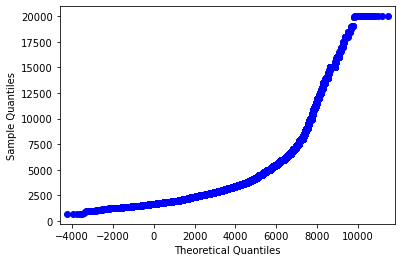

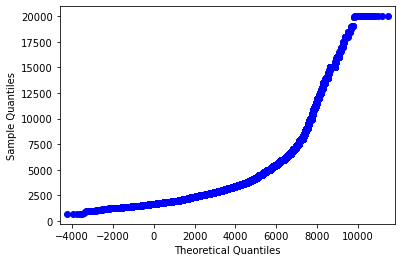

In [25]:
sm.qqplot(price, loc=price.mean(), scale=price.std())

Q-Q график исходного признака

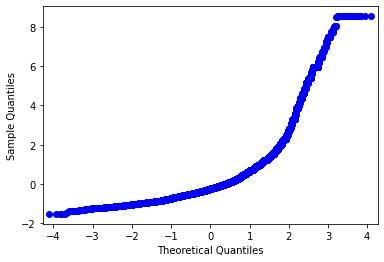

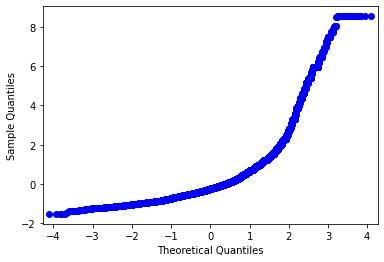

In [26]:
sm.qqplot(price_z, loc=price_z.mean(), scale=price_z.std())

Q-Q график признака после StandartScaler. Форма не меняется

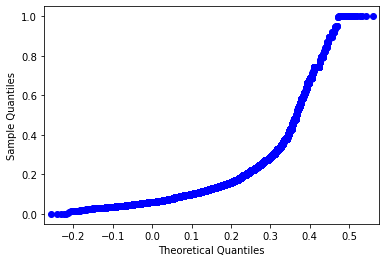

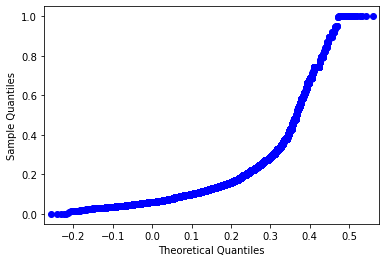

In [27]:
sm.qqplot(price_mm, loc=price_mm.mean(), scale=price_mm.std())

Q-Q график признака после MinMaxScaler. Форма не меняется

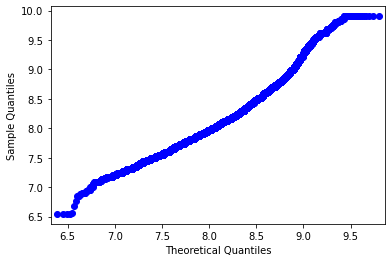

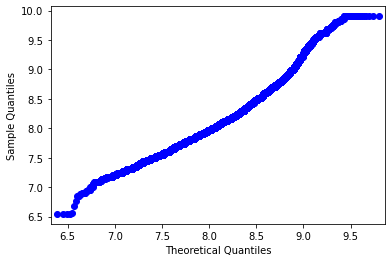

In [28]:
sm.qqplot(price_log, loc=price_log.mean(), scale=price_log.std())

Q-Q график признака после логарифмирования. Дела пошли на поправку!

<a class="anchor" id="6.2.2"></a>

### <span style="color:blue; font-size:1.2em;">6.2.2. Взаимодействия (Interactions)</span>

[Повернутися до змісту](#6)

Если предыдущие преобразования диктовались скорее математикой, то этот пункт снова обоснован природой данных; его можно отнести как к трансформациям, так и к созданию новых признаков.


Снова обратимся к задаче Two Sigma Connect: Rental Listing Inquires. Среди признаков в этой задаче есть количество комнат и стоимость аренды. Житейская логика подсказывает, что стоимость в пересчете на одну комнату более показательна, чем общая стоимость – значит, можно попробовать выделить такой признак.

In [29]:
rooms = df["bedrooms"].apply(lambda x: max(x, .5))

# Избегаем деления на ноль; .5 выбран более или менее произвольно
df["price_per_bedroom"] = df["price"] / rooms

Необязательно руководствоваться жизненной логикой. Если признаков не очень много, вполне можно сгенерировать все возможные взаимодействия и потом отсеять лишние, используя одну из техник, описанных в следующем разделе. Кроме того, не все взаимодействия между признаками должны иметь хоть какой-то физический смысл: например, [часто используемые для линейных моделей](https://habrahabr.ru/company/ods/blog/322076/) полиномиальные признаки (см. [sklearn.preprocessing.PolynomialFeatures](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)) трактовать практически невозможно.

<a class="anchor" id="6.2.3"></a>

### <span style="color:blue; font-size:1.2em;">6.2.3. Заполнение пропусков</span>

[Повернутися до змісту](#6)

Не многие алгоритмы умеют работать с пропущенными значениями "из коробки", а реальный мир часто поставляет данные с пропусками. К счастью, это одна из тех задач, для решения которых не нужно никакого творчества. Обе ключевые для анализа данных python библиотеки предоставляют простые как валенок решения: [pandas.DataFrame.fillna](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) и [sklearn.preprocessing.Imputer](http://scikit-learn.org/stable/modules/preprocessing.html#imputation).

Готовые библиотечные решения не прячут никакой магии за фасадом. Подходы к обработке отсутствующих значений напрашиваются на уровне здравого смысла:

* закодировать отдельным пустым значением типа `"n/a"` (для категориальных переменных);
* использовать наиболее вероятное значение признака (среднее или медиану для вещественных переменных, самое частое для категориальных);
* наоборот, закодировать каким-то невероятным значением (хорошо заходит для моделей, основанных на деревьях решений, т.к. позволяет сделать разделение на пропущенные и непропущенные значения);
* для упорядоченных данных (например, временных рядов) можно брать соседнее значение – следующее или предыдущее.

<img src="https://raw.githubusercontent.com/radiukpavlo/Intelligent-data-analysis/main/03_img/6_2_3_value-error.png" align="center" width=70% height=70%>

Удобство использования библиотечных решений иногда подсказывает воткнуть что-то вроде `df = df.fillna(0)` и не париться о пропусках. Но это не самое разумное решение: большая часть времени обычно уходит не на построение модели, а на подготовку данных; бездумное неявное заполнение пропусков может спрятать баг в обработке и испортить модель.

<a class="anchor" id="6.3"></a>

## <span style="color:blue; font-size:1.2em;">6.3. Выбор признаков (Feature selection)</span>

[Повернутися до змісту](#6)

Зачем вообще может понадобиться выбирать фичи? Кому-то эта идея может показаться контринтуитивной, но на самом деле есть минимум две важные причины избавляться от неважных признаков. Первая понятна всякому инженеру: чем больше данных, тем выше вычислительная сложность. Пока мы балуемся с игрушечными датасетами, размер данных – это не проблема, а для реального нагруженного продакшена лишние сотни признаков могут быть ощутимы. Другая причина – некоторые алгоритмы принимают шум (неинформативные признаки) за сигнал, переобучаясь.

<a class="anchor" id="6.3.1"></a>

### <span style="color:blue; font-size:1.2em;">6.3.1 Статистические подходы</span>

[Повернутися до змісту](#6)

Самый очевидный кандидат на отстрел – признак, у которого значение неизменно, т.е. не содержит вообще никакой информации. Если немного отойти от этого вырожденного случая, резонно предположить, что низковариативные признаки скорее хуже, чем высоковариативные. Так можно придти к идее отсекать признаки, дисперсия которых ниже определенной границы.

In [30]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import make_classification

x_data_generated, y_data_generated = make_classification()
x_data_generated.shape

(100, 20)

In [31]:
VarianceThreshold(.7).fit_transform(x_data_generated).shape

(100, 20)

In [32]:
VarianceThreshold(.8).fit_transform(x_data_generated).shape

(100, 19)

In [33]:
VarianceThreshold(.9).fit_transform(x_data_generated).shape

(100, 13)

Есть и другие способы, также [основанные на классической статистике](http://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection).

In [34]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

x_data_kbest = SelectKBest(f_classif, k=5).fit_transform(x_data_generated, y_data_generated)
x_data_varth = VarianceThreshold(.9).fit_transform(x_data_generated)

In [35]:
cross_val_score(LogisticRegression(), x_data_generated, y_data_generated, scoring='neg_log_loss').mean()

-0.4152537110506569

In [36]:
cross_val_score(LogisticRegression(), x_data_kbest, y_data_generated, scoring='neg_log_loss').mean()

-0.3401036044035789

In [37]:
cross_val_score(LogisticRegression(), x_data_varth, y_data_generated, scoring='neg_log_loss').mean()

-0.39325462140326295

Видно, что отобранные фичи повысили качество классификатора. Понятно, что этот пример сугубо искусственный, тем не менее, прием достоин проверки и в реальных задачах.

<a class="anchor" id="6.3.2"></a>

### <span style="color:blue; font-size:1.2em;">6.3.2. Отбор с использованием моделей</span>

[Повернутися до змісту](#6)

Другой подход: использовать какую-то baseline модель для оценки признаков, при этом модель должна явно показывать важность использованных признаков. Обычно используются два типа моделей: какая-нибудь "деревянная" композиция (например, [Random Forest](https://nbviewer.jupyter.org/github/soolstafir/Machine-learning-course/blob/master/Lections/ml_lection05_bagging_rf/ml_lection05_part01_bagging.ipynb)) или линейная модель с Lasso регуляризацией, склонной обнулять веса слабых признаков. Логика интутивно понятна: если признаки явно бесполезны в простой модели, то не надо тянуть их и в более сложную.

In [38]:
# Синтетический пример

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

x_data_generated, y_data_generated = make_classification()

pipe = make_pipeline(SelectFromModel(estimator=RandomForestClassifier()), LogisticRegression())

lr = LogisticRegression()
rf = RandomForestClassifier()

print(cross_val_score(lr, x_data_generated, y_data_generated, scoring='neg_log_loss').mean())
print(cross_val_score(rf, x_data_generated, y_data_generated, scoring='neg_log_loss').mean())
print(cross_val_score(pipe, x_data_generated, y_data_generated, scoring='neg_log_loss').mean())

-0.33073499023791464
-0.31635316423078147
-0.26489383197265115


Нельзя забывать, что это тоже не серебряная пуля — может получиться даже хуже.

In [39]:
# Давайте вернемся к датасету Renthop.

x_data, y_data = get_data() 
x_data = x_data_generated
y_data = y_data_generated

pipe1 = make_pipeline(StandardScaler(), SelectFromModel(estimator=RandomForestClassifier()), LogisticRegression())

pipe2 = make_pipeline(StandardScaler(), LogisticRegression())

rf = RandomForestClassifier()

print('LR + selection: ', cross_val_score(pipe1, x_data, y_data, scoring='neg_log_loss').mean())
print('LR: ', cross_val_score(pipe2, x_data, y_data, scoring='neg_log_loss').mean())
print('RF: ', cross_val_score(rf, x_data, y_data, scoring='neg_log_loss').mean())

NameError: name 'get_data' is not defined

Стало только хуже!

<a class="anchor" id="6.3.3"></a>

### <span style="color:blue; font-size:1.2em;"> 6.3.3. Перебор</span>

[Повернутися до змісту](#6)

Наконец, самый надежный, но и самый вычислительно сложный способ основан на банальном переборе: обучаем модель на подмножестве "фичей", запоминаем результат, повторяем для разных подмножеств, сравниваем качество моделей. Такой подход называется [Exhaustive Feature Selection](http://rasbt.github.io/mlxtend/user_guide/feature_selection/ExhaustiveFeatureSelector/).


Перебирать все комбинации – обычно слишком долго, так что можно пробовать уменьшить пространство перебора. Фиксируем небольшое число N, перебираем все комбинации по N признаков, выбираем лучшую комбинацию, потом перебираем комбинации из N+1 признаков так, что предыдущая лучшая комбинация признаков зафиксирована, а перебирается только новый признак. Таким образом можно перебирать, пока не упремся в максимально допустимое число признаков или пока качество модели не перестанет значимо расти. Этот алгоритм называется [Sequential Feature Selection](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/).


Этот же алгоритм можно развернуть: начинать с полного пространства признаков и выкидывать признаки по одному, пока это не портит качество модели или пока не достигнуто желаемое число признаков.

In [ ]:
# Установить mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector

selector = SequentialFeatureSelector(LogisticRegression(), scoring='neg_log_loss', 
                                     verbose=2, k_features=3, forward=False, n_jobs=-1)

selector.fit(x_data, y_data)

Посмотрите, как этот подход был реализован в одном простом, но элегантном [ядре Kaggle](https://www.kaggle.com/arsenyinfo/easy-feature-selection-pipeline-0-55-at-lb).